<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/MNIST_MLP_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 12/6/18.** 

# Multi-Layer Perceptron, MNIST
---
In this notebook, I will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [0]:
### Install PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
### Import packages
import torch
import numpy as np
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import  SubsetRandomSampler

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

This cell will create DataLoaders for each of our datasets.

In [0]:
### Number of subprocesses to use for data loading
num_workers = 0
### How many samples per batch to load
batch_size = 20
### Validation size
valid_size = 0.2
### Convert data to torch.FloatTensor
transform = transforms.ToTensor()

### Choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

### Validation indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

### Define samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)                                      

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

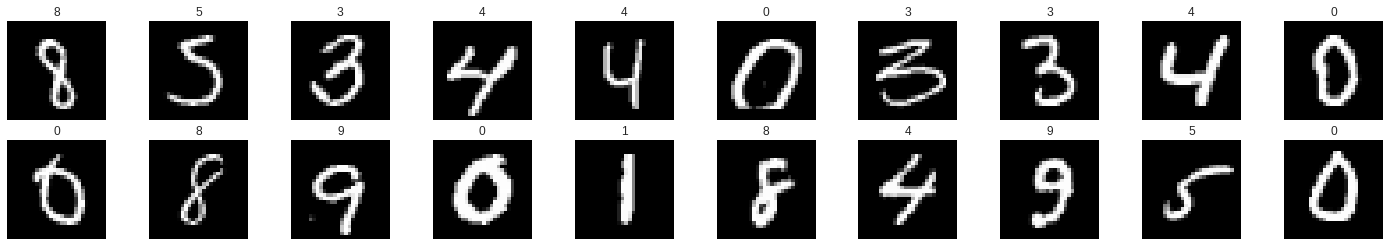

In [61]:
%matplotlib inline
    
### Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

### Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ### Print out the correct label for each image
    ### .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

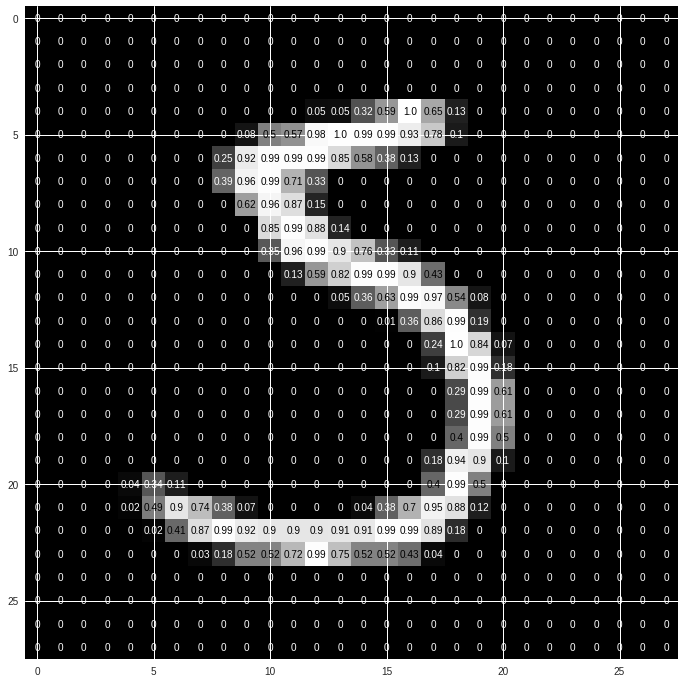

In [62]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [63]:
### Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ### Hidden layers
        hidden_1 = 512 # nodes
        hidden_2 = 512 # nodes 
        
        self.fc1 = nn.Linear(28 *28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)  
                
    def forward(self, x):
        ### Flatten image input
        x = x.view(-1, 28 * 28)
        
        ### Forward flow
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

### Initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [0]:
### Specify loss and optimization functions

### Specify loss function
criterion = nn.CrossEntropyLoss()

### Specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [65]:
### Train and validate the model

### Number of epochs to train the model
n_epochs = 5  

### Minimum validation loss
valid_loss_min = np.Inf
 
for epoch in range(n_epochs):
    ### Monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
     
    ### Training loop 
    model.train()
    
    for data, target in train_loader:
        
        ### Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        ### Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        ### Calculate the loss
        loss = criterion(output, target)
        
        ### Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        ### Perform a single optimization step (parameter update)
        optimizer.step()
        
        ### Update running training loss
        train_loss += loss.item()*data.size(0)        

    ### Validation loop     
    model.eval() 
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        
    ### Print training statistics 
    ### Calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)        
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    ### Save model 
    if valid_loss <= valid_loss_min:
       print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...".format(
       valid_loss_min,
       valid_loss))
       
       torch.save(model.state_dict(), 'model.pt')
       valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.750135 	Validation Loss: 0.075987
Validation loss decreased (inf --> 0.075987). Saving model ...
Epoch: 2 	Training Loss: 0.282840 	Validation Loss: 0.058364
Validation loss decreased (0.075987 --> 0.058364). Saving model ...
Epoch: 3 	Training Loss: 0.226040 	Validation Loss: 0.048820
Validation loss decreased (0.058364 --> 0.048820). Saving model ...
Epoch: 4 	Training Loss: 0.190464 	Validation Loss: 0.041686
Validation loss decreased (0.048820 --> 0.041686). Saving model ...
Epoch: 5 	Training Loss: 0.161775 	Validation Loss: 0.035969
Validation loss decreased (0.041686 --> 0.035969). Saving model ...


In [0]:
### Load the best model 
model.load_state_dict(torch.load('model.pt'))

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [67]:
### Initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

### Testing loop
model.eval() 

for data, target in test_loader:
    ### Forward pass
    output = model(data)
    
    ### Calculate the loss
    loss = criterion(output, target)
    
    ### Update test loss 
    test_loss += loss.item()*data.size(0)
    
    ### Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    ### Compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    ### Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

### Calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.166353

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 97% (1112/1135)
Test Accuracy of     2: 95% (982/1032)
Test Accuracy of     3: 95% (960/1010)
Test Accuracy of     4: 94% (926/982)
Test Accuracy of     5: 93% (832/892)
Test Accuracy of     6: 96% (921/958)
Test Accuracy of     7: 93% (962/1028)
Test Accuracy of     8: 92% (903/974)
Test Accuracy of     9: 93% (945/1009)

Test Accuracy (Overall): 95% (9511/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

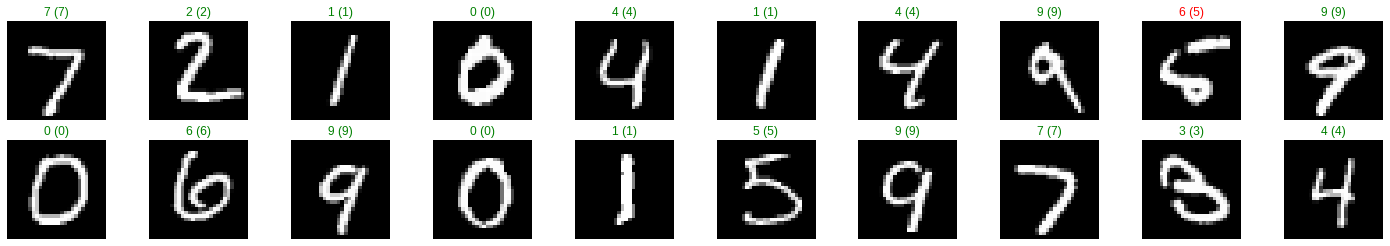

In [68]:
### Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

### Get sample outputs
output = model(images)

### Convert output probabilities to predicted class
_, preds = torch.max(output, 1)

### Prep images for display
images = images.numpy()

### Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))